**CIN0137 - Banco de Dados**
# Recife ITBI ETL Data Pipeline

This project presents a complete ETL (Extract, Transform, Load) pipeline for Recife's ITBI (Imposto de Transmissão de Bens Imóveis) datasets covering the years 2023, 2024, and 2025. The notebook demonstrates robust data extraction, cleaning, visualization,transformation, and consolidation processes, followed by insertion into a PostgreSQL database.

## SETUP

This section prepares the environment for the Recife ITBI Data Pipeline project. Here, we install and import all necessary Python libraries for data extraction, transformation, analysis, and database integration. The setup ensures your system is ready to process ITBI datasets and interact with PostgreSQL.

**Required Libraries:**

- **numpy**: Numerical operations and array handling
- **pandas**: Data manipulation and analysis
- **zipfile**: File compression and extraction
- **os**: File system operations
- **datetime**: Date and time utilities
- **psycopg2**: PostgreSQL database adapter
- **sqlalchemy**: Database toolkit for Python
- **json**: Configuration file management

In [1]:
# Importing libraries required to clean, standardize, and prepare the dataset for futher analysis.

import math
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

import time
start_time  = time.time()

**Data Loading**

After installing and importing the libraries, the setup phase also loads the ITBI datasets for the years 2023, 2024, and 2025 directly from the Recife open data portal. The datasets are read into pandas DataFrames and stored for further ETL processing. This ensures that all data is available and ready for cleaning, transformation, and analysis in the subsequent steps.

In [2]:
# Define the directory path where datasets will be stored
dataset_directory = "datasets"

# Create the directory if it doesn't exist, avoiding errors if it already exists
os.makedirs(dataset_directory, exist_ok=True)

# Define dataset URLs
dataset_sources = {
    "2023": "http://dados.recife.pe.gov.br/dataset/28e3e25e-a9a7-4a9f-90a8-bb02d09cbc18/resource/a01e3b82-055b-4139-b495-e54ec5196f54/download/itbi_2023.csv",
    "2024": "http://dados.recife.pe.gov.br/dataset/28e3e25e-a9a7-4a9f-90a8-bb02d09cbc18/resource/c3feb7bb-4a76-4ddf-becb-ea77f66c23d0/download/itbi_2024.csv",
    "2025": "http://dados.recife.pe.gov.br/dataset/28e3e25e-a9a7-4a9f-90a8-bb02d09cbc18/resource/97bbfc62-efb2-493f-9631-09eb05f980d7/download/itbi_2025.csv"
}

datasets_dict = {}  # Dictionary to store the datasets

for load_year, data_url in dataset_sources.items():
    try:
        # Try to load the CSV
        temp_dataframe = pd.read_csv(data_url, sep=';', encoding='utf-8')
        
        # Check if DataFrame is not empty
        if temp_dataframe.empty:
            raise ValueError("Dataset loaded is empty")
        
        # Save dataset in dictionary for later manipulation
        datasets_dict[load_year] = temp_dataframe.copy()  # Create an independent copy
        
    except Exception as load_error:
        print(f"Error loading data for {load_year}: {type(load_error).__name__}")
        print(f"Details: {str(load_error)}")
        del load_error

# Clean up loop variables
del load_year, data_url, temp_dataframe

staging_dataset = pd.concat(datasets_dict.values(), ignore_index=True)
print(staging_dataset.info())
staging_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37933 entries, 0 to 37932
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   logradouro          37933 non-null  object 
 1   numero              37933 non-null  int64  
 2   complemento         34309 non-null  object 
 3   valor_avaliacao     37933 non-null  float64
 4   bairro              37933 non-null  object 
 5   cidade              37933 non-null  object 
 6   uf                  37933 non-null  object 
 7   ano_construcao      37933 non-null  int64  
 8   area_terreno        37933 non-null  object 
 9   area_construida     37933 non-null  object 
 10  fracao_ideal        37933 non-null  object 
 11  padrao_acabamento   37933 non-null  object 
 12  tipo_construcao     37933 non-null  object 
 13  tipo_ocupacao       37933 non-null  object 
 14  data_transacao      37933 non-null  object 
 15  estado_conservacao  37933 non-null  object 
 16  tipo

,logradouro,numero,complemento,valor_avaliacao,bairro,cidade,uf,ano_construcao,area_terreno,area_construida,...,tipo_ocupacao,data_transacao,estado_conservacao,tipo_imovel,sfh,cod_logradouro,latitude,longitude,ano,Distrito
0,av norte miguel arraes de alencar,3071,NaN,1068562.63,Encruzilhada,Recife,PE,1997,"438,0","511,0",...,COMERCIAL COM LIXO ORGANICO,2023-12-21,Regular,Galpão,0.0,46540,-8.034273,-34.896337,2023,1
1,av norte miguel arraes de alencar,3029,NaN,1500000.00,Encruzilhada,Recife,PE,1957,"779,33","582,44",...,COMERCIAL SEM LIXO ORGANICO,2023-11-17,Regular,Casa,0.0,46540,-8.034435,-34.896335,2023,1
2,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,Recife,PE,1970,"562,05","121,0",...,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1
3,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,Recife,PE,1970,"562,05","121,0",...,RESIDENCIAL,2023-09-26,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1
4,rua belmiro correa,133,apto 2,110000.00,Encruzilhada,Recife,PE,1970,"562,05","81,0",...,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1


## Data Cleaning

**Renaming unclear columns**

In [3]:
def rename_sfh_column(df):
    """
    Renomeia a coluna 'sfh' para 'valores_financiados_sfh' para melhor clareza
    
    Args:
        df (pd.DataFrame): DataFrame com dados ITBI
    
    Returns:
        pd.DataFrame: DataFrame com coluna renomeada
    """
    df_transformed = df.rename(columns={'sfh': 'valores_financiados_sfh'})
    print(f"Coluna 'sfh' renomeada para 'valores_financiados_sfh'")
    return df_transformed

staging_dataset = rename_sfh_column(staging_dataset)
staging_dataset.head()

Coluna 'sfh' renomeada para 'valores_financiados_sfh'


,logradouro,numero,complemento,valor_avaliacao,bairro,cidade,uf,ano_construcao,area_terreno,area_construida,...,tipo_ocupacao,data_transacao,estado_conservacao,tipo_imovel,valores_financiados_sfh,cod_logradouro,latitude,longitude,ano,Distrito
0,av norte miguel arraes de alencar,3071,NaN,1068562.63,Encruzilhada,Recife,PE,1997,"438,0","511,0",...,COMERCIAL COM LIXO ORGANICO,2023-12-21,Regular,Galpão,0.0,46540,-8.034273,-34.896337,2023,1
1,av norte miguel arraes de alencar,3029,NaN,1500000.00,Encruzilhada,Recife,PE,1957,"779,33","582,44",...,COMERCIAL SEM LIXO ORGANICO,2023-11-17,Regular,Casa,0.0,46540,-8.034435,-34.896335,2023,1
2,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,Recife,PE,1970,"562,05","121,0",...,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1
3,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,Recife,PE,1970,"562,05","121,0",...,RESIDENCIAL,2023-09-26,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1
4,rua belmiro correa,133,apto 2,110000.00,Encruzilhada,Recife,PE,1970,"562,05","81,0",...,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1


**Remove geographic redundant columns**

In [4]:
def remove_redundant_geographic_columns(df):
    """
    Remove colunas geográficas redundantes ('cidade' e 'uf') 
    pois contêm apenas valores uniformes (Recife e PE)
    
    Args:
        df (pd.DataFrame): DataFrame com dados ITBI
    
    Returns:
        pd.DataFrame: DataFrame sem colunas redundantes
    """
    columns_to_drop = ['cidade', 'uf']
    existing_columns = [col for col in columns_to_drop if col in df.columns]
    
    if existing_columns:
        df_transformed = df.drop(existing_columns, axis=1)
        print(f"Colunas removidas: {existing_columns}")
    else:
        df_transformed = df.copy()
        print("Erro: Colunas 'cidade' e 'uf' não encontradas")
    
    return df_transformed

staging_dataset = remove_redundant_geographic_columns(staging_dataset)
staging_dataset.head()

Colunas removidas: ['cidade', 'uf']


,logradouro,numero,complemento,valor_avaliacao,bairro,ano_construcao,area_terreno,area_construida,fracao_ideal,padrao_acabamento,...,tipo_ocupacao,data_transacao,estado_conservacao,tipo_imovel,valores_financiados_sfh,cod_logradouro,latitude,longitude,ano,Distrito
0,av norte miguel arraes de alencar,3071,NaN,1068562.63,Encruzilhada,1997,"438,0","511,0","1,0",Médio,...,COMERCIAL COM LIXO ORGANICO,2023-12-21,Regular,Galpão,0.0,46540,-8.034273,-34.896337,2023,1
1,av norte miguel arraes de alencar,3029,NaN,1500000.00,Encruzilhada,1957,"779,33","582,44","1,0",Médio,...,COMERCIAL SEM LIXO ORGANICO,2023-11-17,Regular,Casa,0.0,46540,-8.034435,-34.896335,2023,1
2,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,1970,"562,05","121,0","0,27191",Simples,...,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1
3,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,1970,"562,05","121,0","0,27191",Simples,...,RESIDENCIAL,2023-09-26,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1
4,rua belmiro correa,133,apto 2,110000.00,Encruzilhada,1970,"562,05","81,0","0,18202",Simples,...,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1


**Convert values to appropriate types**

In [5]:
def standardize_decimal_format(value):
    """
    Converte formato decimal brasileiro (vírgula) para formato internacional (ponto)
    
    Args:
        value: Valor a ser convertido
    
    Returns:
        str: Valor com formato decimal padronizado
    """
    if pd.isna(value):
        return value
    return str(value).replace(',', '.')

def convert_valor_avaliacao_to_float(df):
    """
    Converte coluna 'valor_avaliacao' de object para float
    após padronizar o formato decimal
    
    Args:
        df (pd.DataFrame): DataFrame com dados ITBI
    
    Returns:
        pd.DataFrame: DataFrame com valor_avaliacao como float
    """
    df_transformed = df.copy()
    
    if 'valor_avaliacao' in df_transformed.columns:
        # Padronizar formato decimal (vírgula para ponto)
        df_transformed['valor_avaliacao'] = df_transformed['valor_avaliacao'].apply(standardize_decimal_format)
        
        # Converter para float
        df_transformed['valor_avaliacao'] = df_transformed['valor_avaliacao'].astype('float')
    
    return df_transformed

def convert_to_category(df):

    """
    Convert specific object columns to category type for better memory usage and performance
    
    Args:
        df (pd.DataFrame): DataFrame with ITBI data
    
    Returns:
        pd.DataFrame: DataFrame with categorical columns optimized
    """
    
    df_transformed = df.copy()
    
    # Define columns that should be categorical
    categorical_columns = ['padrao_acabamento', 'tipo_construcao', 'tipo_ocupacao', 'estado_conservacao', 'tipo_imovel', 'ano']
    
    
    for column in categorical_columns:
        if column in df_transformed.columns:
            # Convert to category
            df_transformed[column] = df_transformed[column].astype('category')
    
    return df_transformed
    
def convert_area_terreno_to_float(df):
    """
    Converte coluna 'area_terreno' de object para float
    após padronizar o formato decimal
    
    Args:
        df (pd.DataFrame): DataFrame com dados ITBI
    
    Returns:
        pd.DataFrame: DataFrame com area_terreno como float
    """
    df_transformed = df.copy()
    
    if 'area_terreno' in df_transformed.columns:
        # Padronizar formato decimal e converter para float
        df_transformed['area_terreno'] = (df_transformed['area_terreno']
                                        .astype(str)
                                        .str.replace(',', '.')
                                        .astype(float))
    
    return df_transformed

def convert_area_construida_to_float(df):
    """
    Converte coluna 'area_construida' de object para float
    após padronizar o formato decimal
    
    Args:
        df (pd.DataFrame): DataFrame com dados ITBI
    
    Returns:
        pd.DataFrame: DataFrame com area_construida como float
    """
    df_transformed = df.copy()
    
    if 'area_construida' in df_transformed.columns:
        # Padronizar formato decimal e converter para float
        df_transformed['area_construida'] = (df_transformed['area_construida']
                                           .astype(str)
                                           .str.replace(',', '.')
                                           .astype(float))
    
    return df_transformed

def convert_fracao_ideal_to_float(df):
    df_transformed = df.copy()

    if 'fracao_ideal' in df_transformed.columns:
        df_transformed['fracao_ideal'] = (df_transformed['fracao_ideal'].astype(str).str.replace(',','.').astype(float))

    
    return df_transformed


def convert_data_transacao_to_timestamp(df):

    df_transformed = df.copy()

    if 'data_transacao' in df_transformed.columns :
        df_transformed['data_transacao'] = pd.to_datetime(df_transformed['data_transacao'])

    return df_transformed


def convert_valores_financiados_sfh_to_float(df):

    df_transformed = df.copy()

    if 'valores_financiados_sfh' in df_transformed.columns :
        df_transformed['valores_financiados_sfh'] = (df_transformed['valores_financiados_sfh'].astype(str).str.replace(',', '.').astype(float)) 

    return df_transformed

def convert_complemento_to_object(df):
    """ Converts the 'complemento' column to object type
    Args:
        df (pd.DataFrame): DataFrame with ITBI data
    Returns:
        pd.DataFrame: DataFrame with 'complemento' as object type
    """
    df_transformed = df.copy()
    if 'complemento' in df_transformed.columns:
        df_transformed['complemento'] = df_transformed['complemento'].astype(object)
    
    return df_transformed

def convert_to_appropiate_types(df):
    df_transformed = df.copy()

    df_transformed = convert_valor_avaliacao_to_float(df_transformed)
    df_transformed = convert_to_category(df_transformed)
    df_transformed = convert_area_terreno_to_float(df_transformed)
    df_transformed = convert_area_construida_to_float(df_transformed)
    df_transformed = convert_data_transacao_to_timestamp(df_transformed)
    df_transformed = convert_fracao_ideal_to_float(df_transformed)
    df_transformed = convert_valores_financiados_sfh_to_float(df_transformed)
    df_transformed = convert_complemento_to_object(df_transformed)
    return df_transformed

staging_dataset = convert_to_appropiate_types(staging_dataset)
print(staging_dataset.info())
staging_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37933 entries, 0 to 37932
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   logradouro               37933 non-null  object        
 1   numero                   37933 non-null  int64         
 2   complemento              34309 non-null  object        
 3   valor_avaliacao          37933 non-null  float64       
 4   bairro                   37933 non-null  object        
 5   ano_construcao           37933 non-null  int64         
 6   area_terreno             37933 non-null  float64       
 7   area_construida          37933 non-null  float64       
 8   fracao_ideal             37933 non-null  float64       
 9   padrao_acabamento        37933 non-null  category      
 10  tipo_construcao          37933 non-null  category      
 11  tipo_ocupacao            37933 non-null  category      
 12  data_transacao           37933 n

,logradouro,numero,complemento,valor_avaliacao,bairro,ano_construcao,area_terreno,area_construida,fracao_ideal,padrao_acabamento,...,tipo_ocupacao,data_transacao,estado_conservacao,tipo_imovel,valores_financiados_sfh,cod_logradouro,latitude,longitude,ano,Distrito
0,av norte miguel arraes de alencar,3071,NaN,1068562.63,Encruzilhada,1997,438.00,511.00,1.00000,Médio,...,COMERCIAL COM LIXO ORGANICO,2023-12-21,Regular,Galpão,0.0,46540,-8.034273,-34.896337,2023,1
1,av norte miguel arraes de alencar,3029,NaN,1500000.00,Encruzilhada,1957,779.33,582.44,1.00000,Médio,...,COMERCIAL SEM LIXO ORGANICO,2023-11-17,Regular,Casa,0.0,46540,-8.034435,-34.896335,2023,1
2,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,Simples,...,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1
3,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,Simples,...,RESIDENCIAL,2023-09-26,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1
4,rua belmiro correa,133,apto 2,110000.00,Encruzilhada,1970,562.05,81.00,0.18202,Simples,...,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1


**Fix encoding issues**

In [6]:
def fix_encoding_issues(text_value):
    """
    Corrige problemas de encoding em caracteres portugueses
    Converte Latin1 mal interpretado para UTF-8 correto
    
    Args:
        text_value: Valor de texto a ser corrigido
    
    Returns:
        str: Texto com encoding corrigido
    """
    if not isinstance(text_value, str):
        return text_value
    try:
        return text_value.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        return text_value

def fix_text_encoding(df):
    """
    Aplica correção de encoding em todas as colunas de texto do DataFrame
    
    Args:
        df (pd.DataFrame): DataFrame com dados ITBI
    
    Returns:
        pd.DataFrame: DataFrame com encoding corrigido
    """
    df_transformed = df.copy()
    
    # Identificar colunas de texto
    text_columns = df_transformed.select_dtypes(include=['object', 'category']).columns
    
    if len(text_columns) > 0:
        for col in text_columns:
            df_transformed[col] = df_transformed[col].apply(fix_encoding_issues)
        
        print(f"Encoding corrigido em {len(text_columns)} colunas de texto")
    else:
        print("Nenhuma coluna de texto encontrada")
    
    return df_transformed

staging_dataset = fix_text_encoding(staging_dataset)

Encoding corrigido em 9 colunas de texto



**Handle missing values**

In [7]:
def handle_missing_values_complemento(df):
    """
    Trata valores ausentes na coluna 'complemento' substituindo por 'não informado'
    
    Args:
        df (pd.DataFrame): DataFrame com dados ITBI
    
    Returns:
        pd.DataFrame: DataFrame com valores ausentes em 'complemento' tratados
    """
    df_transformed = df.copy()
    if 'complemento' in df_transformed.columns:
        # Substituir valores ausentes por 'não informado'
        df_transformed['complemento'] = df_transformed['complemento'].fillna('não informado')
        print("Valores ausentes na coluna 'complemento' foram substituídos por 'não informado'")
    return df_transformed

staging_dataset = handle_missing_values_complemento(staging_dataset)
staging_dataset.head()

Valores ausentes na coluna 'complemento' foram substituídos por 'não informado'


,logradouro,numero,complemento,valor_avaliacao,bairro,ano_construcao,area_terreno,area_construida,fracao_ideal,padrao_acabamento,...,tipo_ocupacao,data_transacao,estado_conservacao,tipo_imovel,valores_financiados_sfh,cod_logradouro,latitude,longitude,ano,Distrito
0,av norte miguel arraes de alencar,3071,não informado,1068562.63,Encruzilhada,1997,438.00,511.00,1.00000,Médio,...,COMERCIAL COM LIXO ORGANICO,2023-12-21,Regular,Galpão,0.0,46540,-8.034273,-34.896337,2023,1
1,av norte miguel arraes de alencar,3029,não informado,1500000.00,Encruzilhada,1957,779.33,582.44,1.00000,Médio,...,COMERCIAL SEM LIXO ORGANICO,2023-11-17,Regular,Casa,0.0,46540,-8.034435,-34.896335,2023,1
2,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,Simples,...,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1
3,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,Simples,...,RESIDENCIAL,2023-09-26,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1
4,rua belmiro correa,133,apto 2,110000.00,Encruzilhada,1970,562.05,81.00,0.18202,Simples,...,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1


**Separating additional information from 'tipo_construcao' category**

In [8]:
import re

def parse_pavimentos(tipo_construcao):
        """
        Parse the construction type string to extract floor information
        """
        if pd.isna(tipo_construcao):
            return 'não especificado'
        
        tipo_str = str(tipo_construcao).lower()
        
        # Check for specific patterns
        if '<= 4 pavimentos' in tipo_str or '<=4 pavimentos' in tipo_str:
            return '<= 4 pavimentos'
        elif '> 4 pavimentos' in tipo_str or '>4 pavimentos' in tipo_str:
            return '> 4 pavimentos'
        
        return 'não especificado'

def clean_tipo_construcao(tipo_construcao):
        """
        Remove pavimento information from the construction type string
        """
        if pd.isna(tipo_construcao):
            return tipo_construcao
        
        tipo_str = str(tipo_construcao)
        
        # Remove pavimento patterns (case insensitive)
        # Remove operators with numbers and pavimentos
        cleaned = re.sub(r'\s*[<>=]*\s*\d+\s*pavimentos?\s*', '', tipo_str, flags=re.IGNORECASE)
        
        # Clean up extra spaces and leading/trailing whitespace
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()
        
        return cleaned

def extract_pavimentos(df, column_name='tipo_construcao'):
    """
    Extract the number of floors (pavimentos) from construction type column
    and create a new column 'quantidade_pavimentos'.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the construction type data
    column_name (str): Name of the column containing construction type info
    
    Returns:
    pd.DataFrame: DataFrame with new 'quantidade_pavimentos' column
    """
    
    # Create a copy of the dataframe to avoid modifying the original
    df_transformed = df.copy()
    
    # Apply the parsing function to create the new column
    df_transformed['quantidade_pavimentos'] = df_transformed[column_name].apply(parse_pavimentos).astype('category')

    df_transformed['tipo_construcao'] = df_transformed[column_name].apply(clean_tipo_construcao).astype('category')
    
    return df_transformed

staging_dataset = extract_pavimentos(staging_dataset)
staging_dataset.head()

,logradouro,numero,complemento,valor_avaliacao,bairro,ano_construcao,area_terreno,area_construida,fracao_ideal,padrao_acabamento,...,data_transacao,estado_conservacao,tipo_imovel,valores_financiados_sfh,cod_logradouro,latitude,longitude,ano,Distrito,quantidade_pavimentos
0,av norte miguel arraes de alencar,3071,não informado,1068562.63,Encruzilhada,1997,438.00,511.00,1.00000,Médio,...,2023-12-21,Regular,Galpão,0.0,46540,-8.034273,-34.896337,2023,1,não especificado
1,av norte miguel arraes de alencar,3029,não informado,1500000.00,Encruzilhada,1957,779.33,582.44,1.00000,Médio,...,2023-11-17,Regular,Casa,0.0,46540,-8.034435,-34.896335,2023,1,não especificado
2,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,Simples,...,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1,<= 4 pavimentos
3,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,Simples,...,2023-09-26,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1,<= 4 pavimentos
4,rua belmiro correa,133,apto 2,110000.00,Encruzilhada,1970,562.05,81.00,0.18202,Simples,...,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1,<= 4 pavimentos


**Separation additional information from 'tipo_ocupacao' category**

In [9]:
def clean_tipo_ocupacao(ocupacao):
    """
    Parse the occupation type string to extract additional information
    """
    if pd.isna(ocupacao):
        return 'não especificado'
    
    ocupacao_str = str(ocupacao).lower()
    
    # Check for specific patterns
    if 'residencial' in ocupacao_str:
        return 'Residencial'
    elif 'comercial' in ocupacao_str:
        return 'Comercial'
    
    return 'não especificado'

def parse_lixo_organico(ocupacao):
    """
    Parse the occupation type string to extract organic waste information
    """
    if pd.isna(ocupacao):
        return 'não especificado'
    
    ocupacao_str = str(ocupacao).lower()
    
    # Check for specific patterns
    if 'com lixo organico' in ocupacao_str:
        return 'sim'
    elif 'sem lixo organico' in ocupacao_str:
        return 'não'
    
    return 'não especificado'

def extract_lixo_organico(df, column_name='tipo_ocupacao'):
    """
    Extract organic waste information from occupation type column
    and create a new column 'lixo_organico'.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the occupation type data
    column_name (str): Name of the column containing occupation type info
    
    Returns:
    pd.DataFrame: DataFrame with new 'lixo_organico' column
    """
    df_transformed = df.copy()
    df_transformed['lixo_organico'] = df_transformed[column_name].apply(parse_lixo_organico).astype('category')
    df_transformed['tipo_ocupacao'] = df_transformed[column_name].apply(clean_tipo_ocupacao).astype('category')

    return df_transformed

staging_dataset = extract_lixo_organico(staging_dataset)
staging_dataset.head()

,logradouro,numero,complemento,valor_avaliacao,bairro,ano_construcao,area_terreno,area_construida,fracao_ideal,padrao_acabamento,...,estado_conservacao,tipo_imovel,valores_financiados_sfh,cod_logradouro,latitude,longitude,ano,Distrito,quantidade_pavimentos,lixo_organico
0,av norte miguel arraes de alencar,3071,não informado,1068562.63,Encruzilhada,1997,438.00,511.00,1.00000,Médio,...,Regular,Galpão,0.0,46540,-8.034273,-34.896337,2023,1,não especificado,sim
1,av norte miguel arraes de alencar,3029,não informado,1500000.00,Encruzilhada,1957,779.33,582.44,1.00000,Médio,...,Regular,Casa,0.0,46540,-8.034435,-34.896335,2023,1,não especificado,não
2,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,Simples,...,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1,<= 4 pavimentos,não especificado
3,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,Simples,...,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1,<= 4 pavimentos,não especificado
4,rua belmiro correa,133,apto 2,110000.00,Encruzilhada,1970,562.05,81.00,0.18202,Simples,...,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1,<= 4 pavimentos,não especificado


## Data Visualization

**By category**

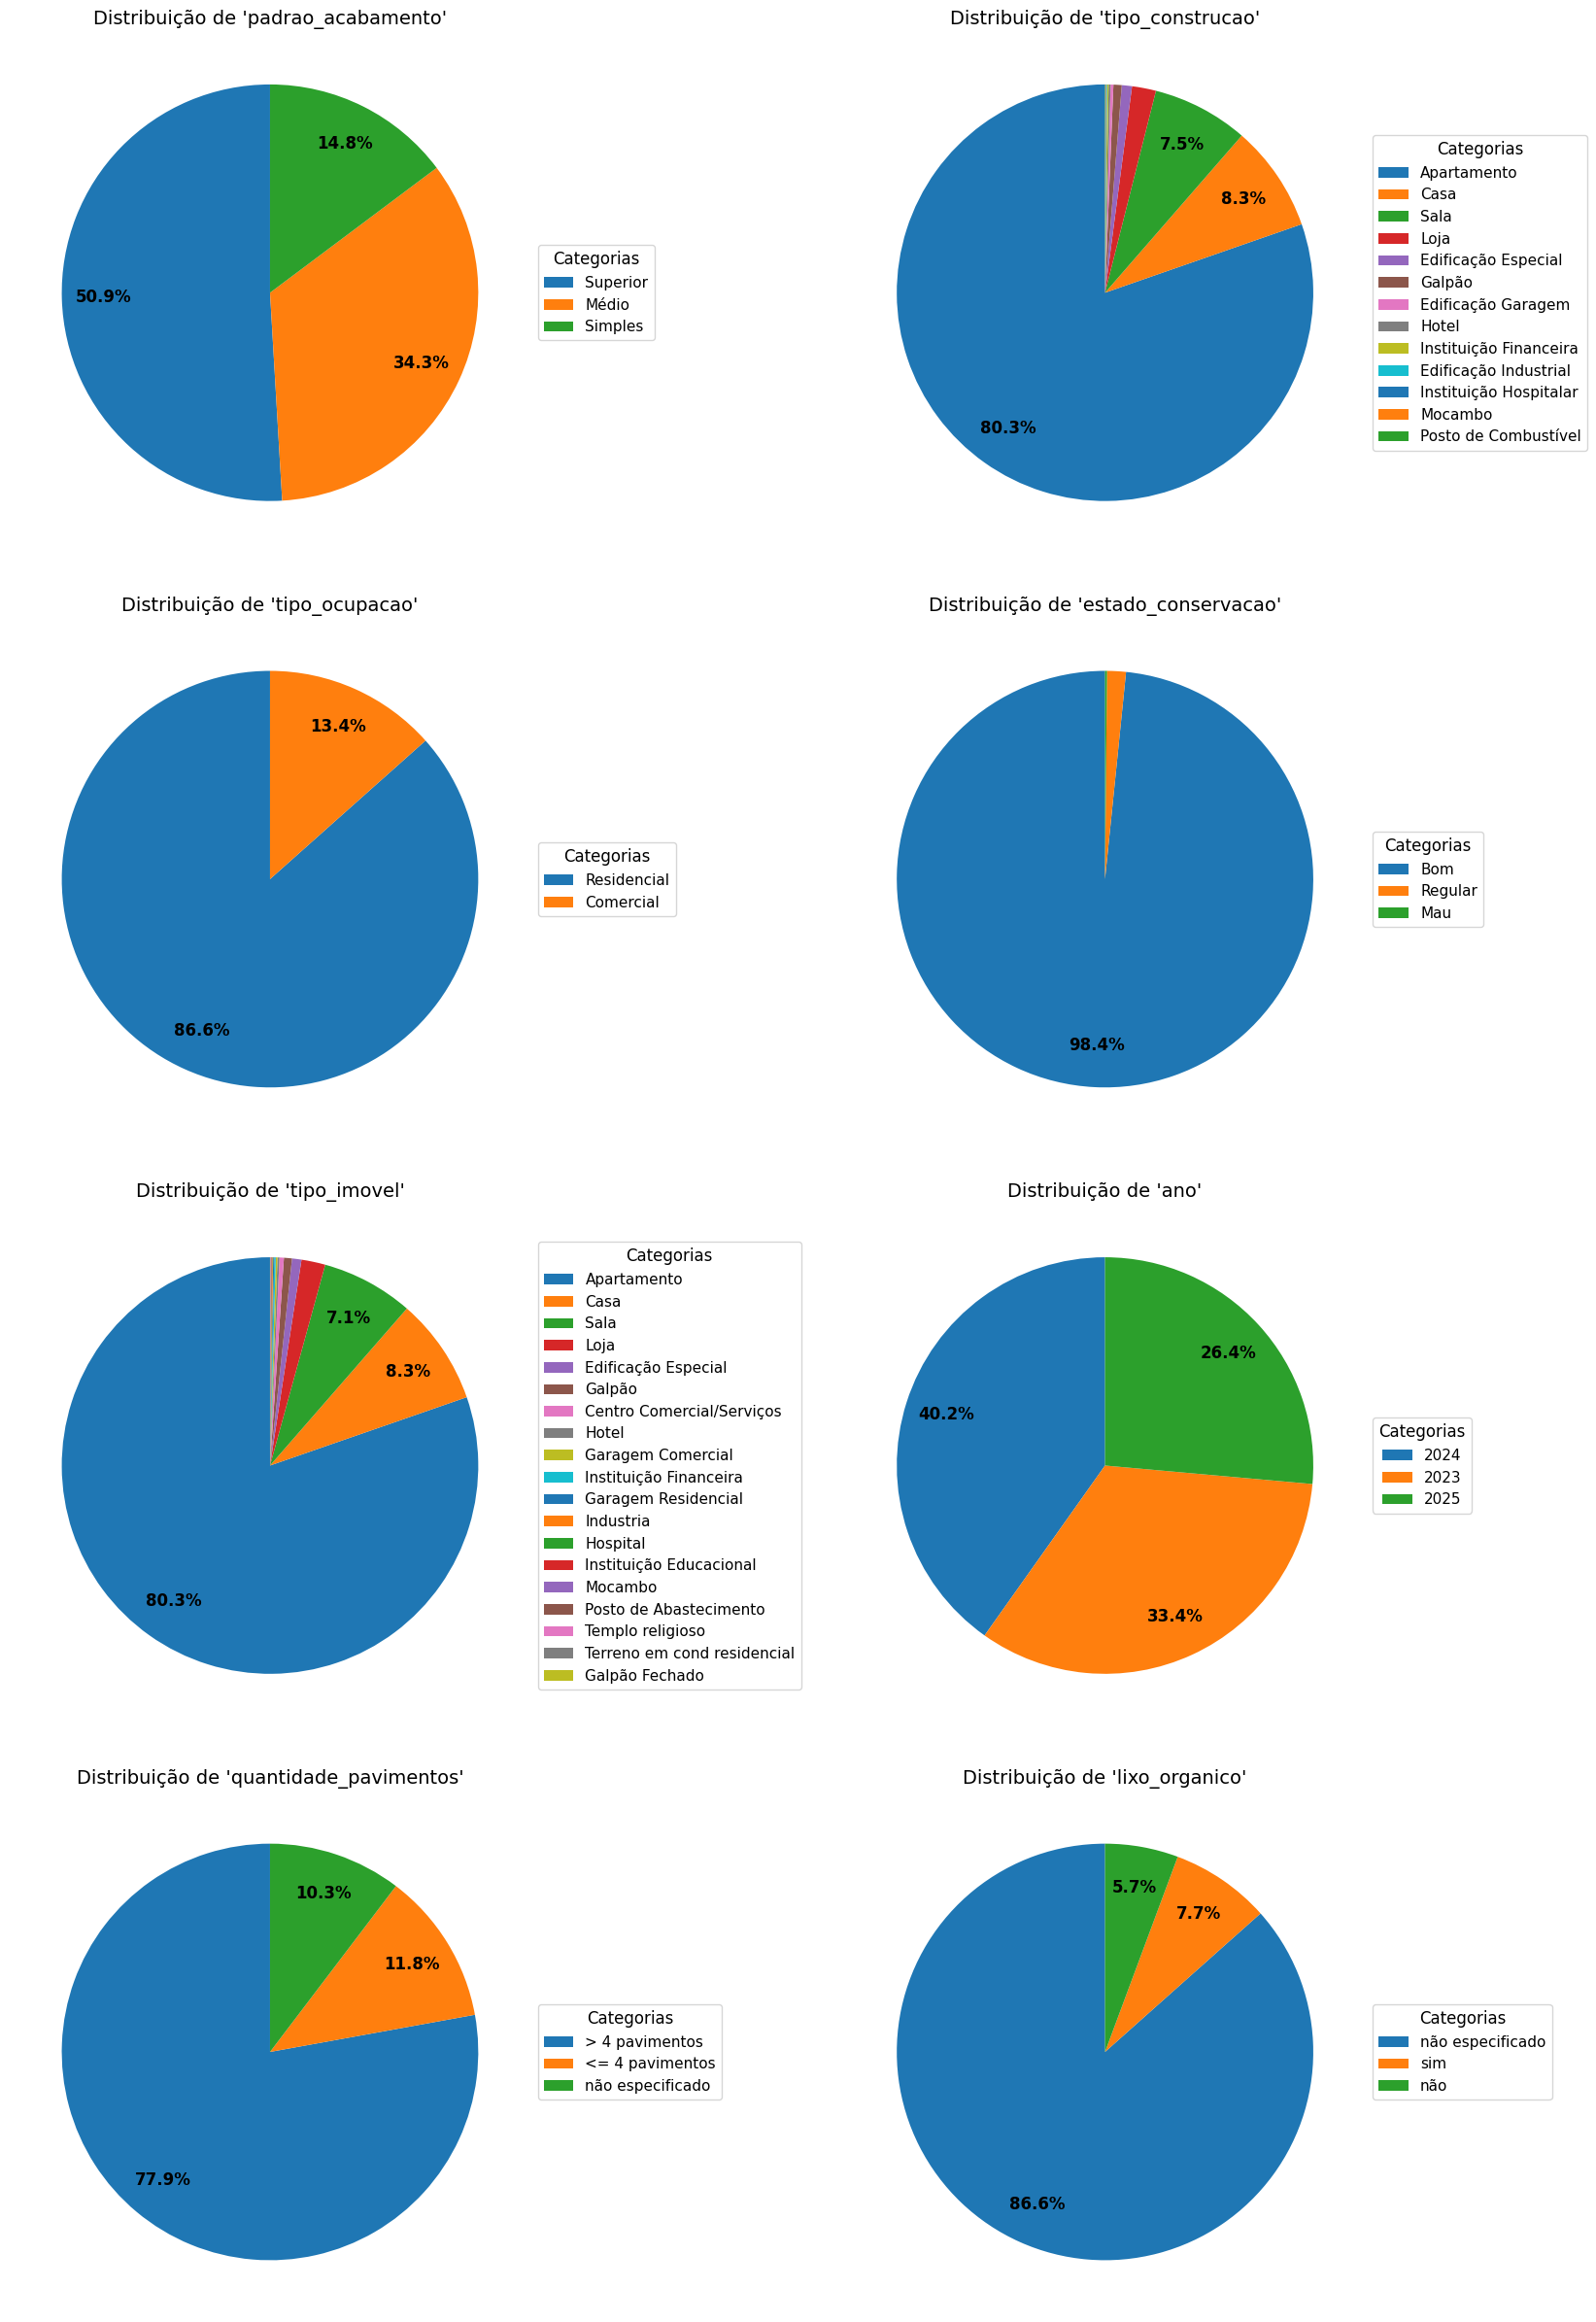

In [10]:
# Pie charts for each categorical column, with improved spacing and no number overlap

categorical_columns = staging_dataset.select_dtypes(include=["category"]).columns
n_cols = 2
n_rows = math.ceil(len(categorical_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9 * n_cols, 6 * n_rows))  # Increased figure size
axes = axes.flatten() if len(categorical_columns) > 1 else [axes]

for idx, col in enumerate(categorical_columns):
    value_counts = staging_dataset[col].value_counts(dropna=True)
    if len(value_counts) > 1:
        wedges, texts, autotexts = axes[idx].pie(
            value_counts,
            autopct=lambda pct: f'{pct:.1f}%' if pct > 2 else '',  # Hide small percentages
            startangle=90,
            labels=None,
            pctdistance=0.8,    # Move percentage labels outward
            labeldistance=1.1,  # Move category labels outward (if used)
        )
        # Make percentage labels larger and bold for readability
        for autotext in autotexts:
            autotext.set_fontsize(12)
            autotext.set_fontweight('bold')
            axes[idx].set_title(f"Distribuição de '{col}'", fontsize=14)
            axes[idx].set_ylabel("")
            axes[idx].legend(
                wedges,
                value_counts.index,
                title="Categorias",
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1),
                fontsize=11,
                title_fontsize=12
            )
    else:
        axes[idx].axis('off')

for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**By numerical values**

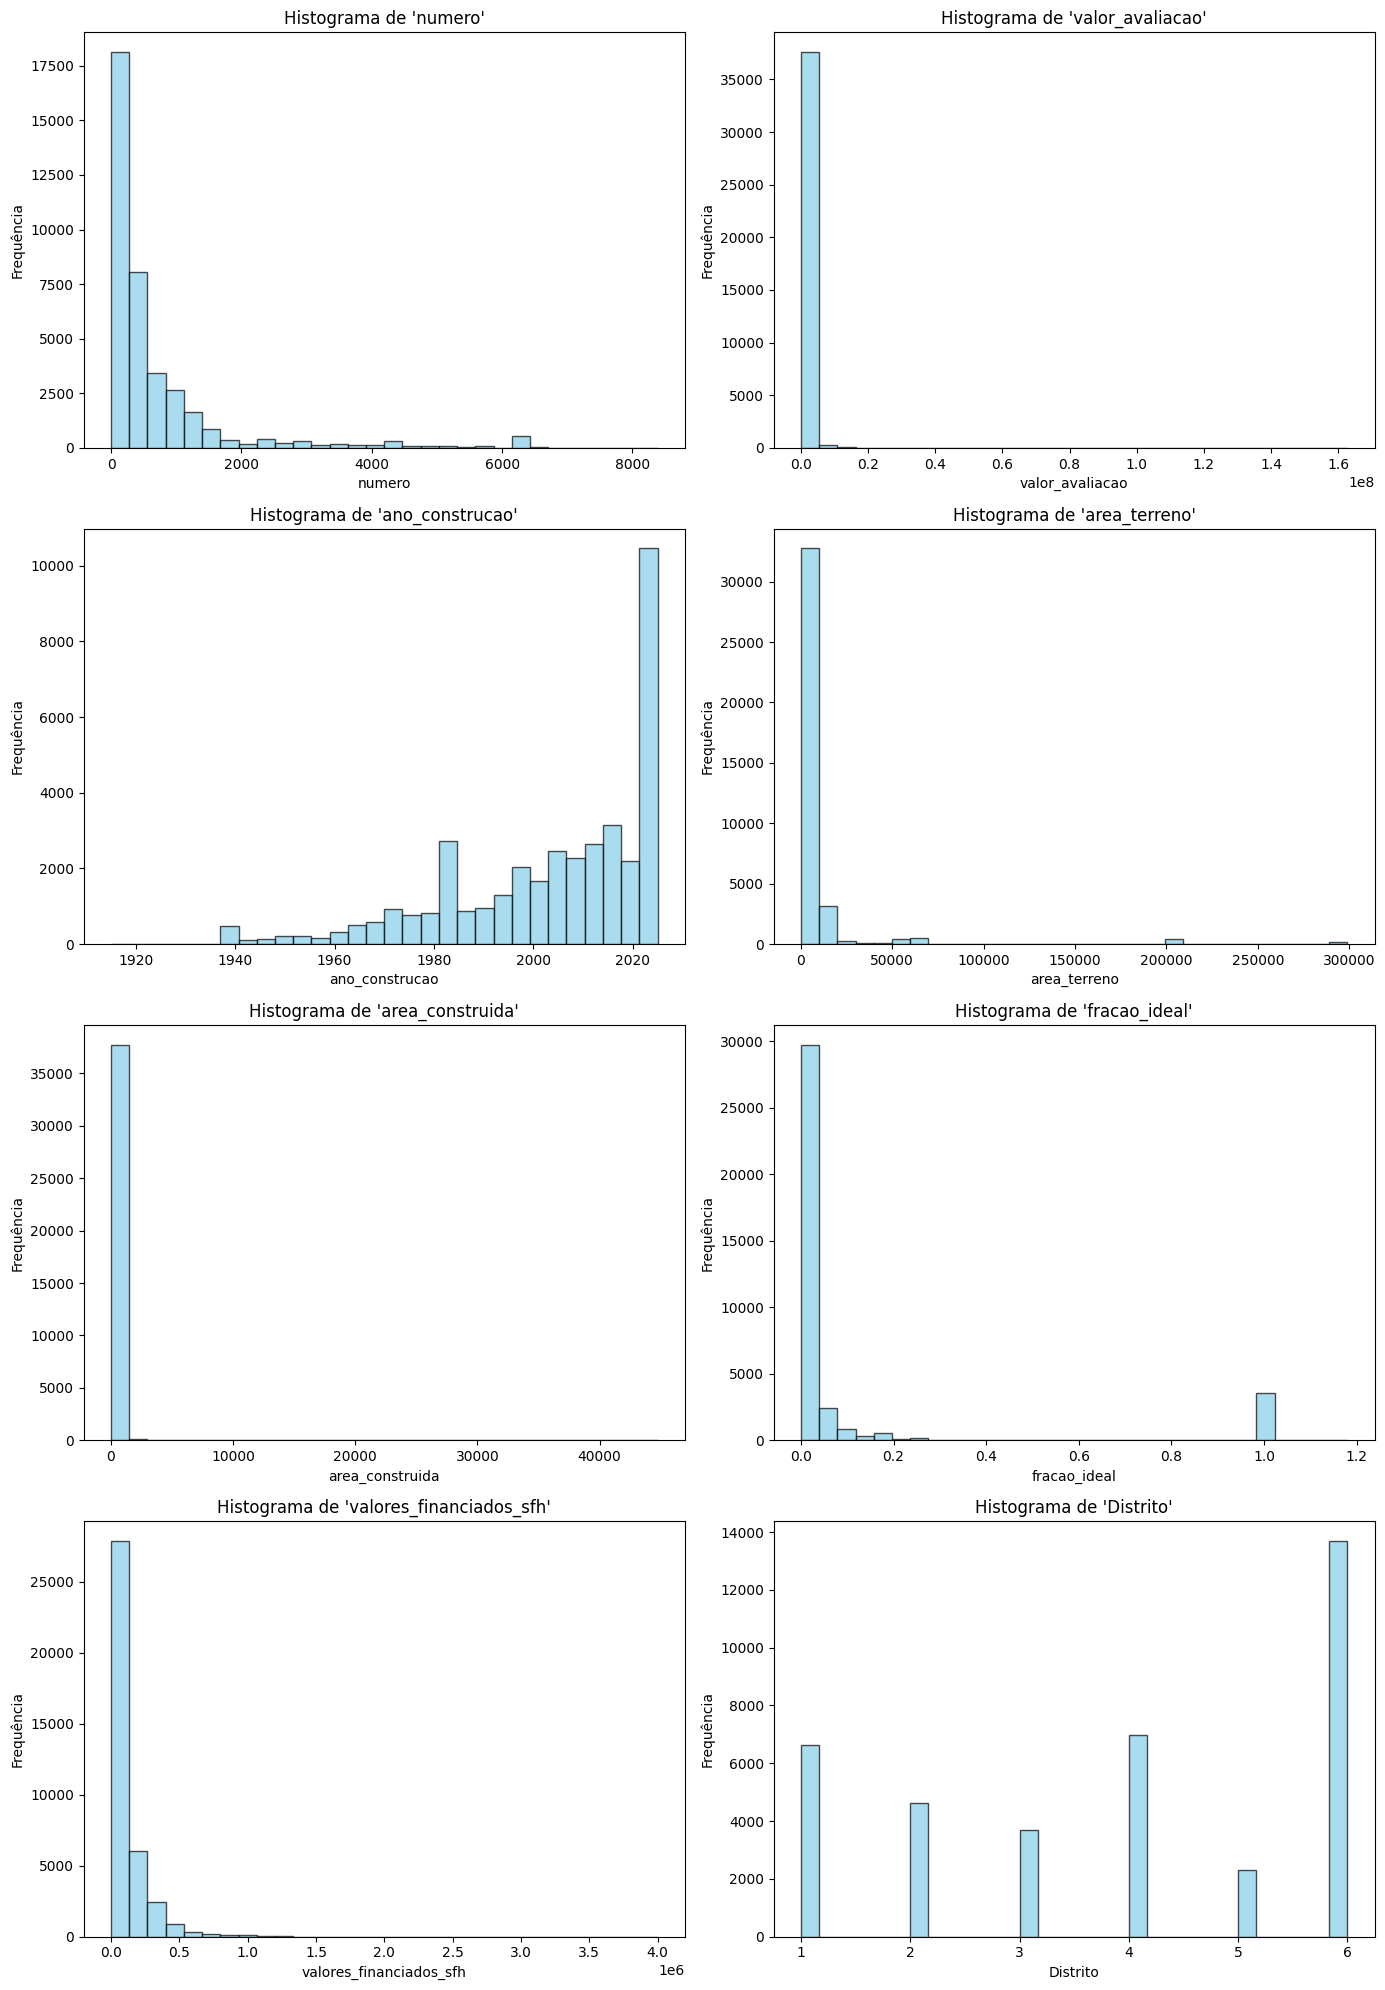

In [11]:
# Unidimensional visualizations (histograms and boxplots) for selected numerical columns (excluding unwanted columns)

import matplotlib.pyplot as plt

# Select numerical columns, excluding specific ones
exclude_cols = ["cod_logradouro", "latitude", "longitude"]
numerical_columns = [
    col for col in staging_dataset.select_dtypes(include=["int64", "float64"]).columns
    if col not in exclude_cols
]

n_cols = 2
n_rows = (len(numerical_columns) + 1) // n_cols

# Histograms
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 5 * n_rows))
axes = axes.flatten() if len(numerical_columns) > 1 else [axes]

for idx, col in enumerate(numerical_columns):
    ax = axes[idx]
    staging_dataset[col].plot.hist(
        bins=30,
        alpha=0.7,
        ax=ax,
        color='skyblue',
        edgecolor='black'
    )
    ax.set_title(f"Histograma de '{col}'")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequência")

for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

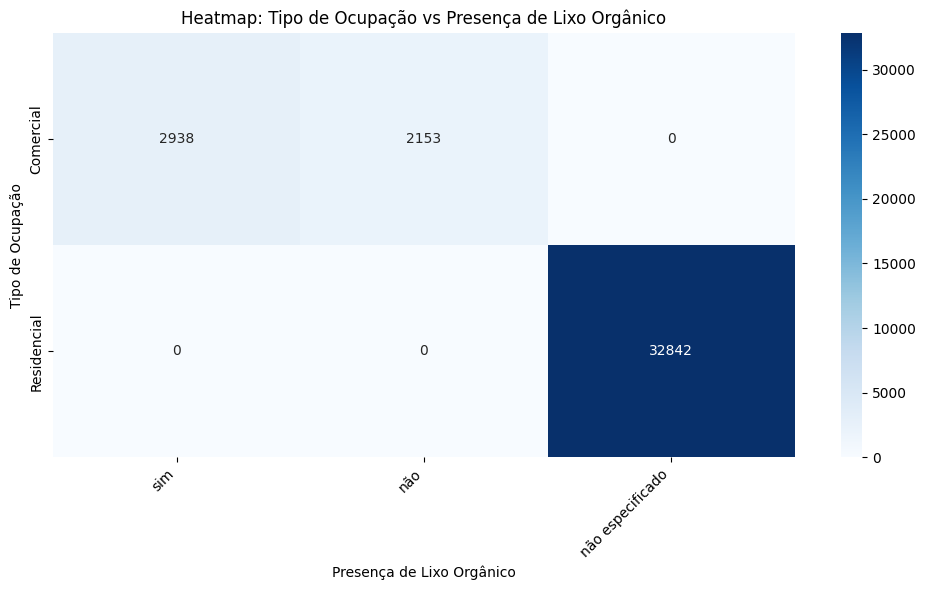

In [12]:
# Heatmap between tipo_ocupacao and lixo_organico
heatmap_data = pd.crosstab(staging_dataset['tipo_ocupacao'], staging_dataset['lixo_organico'])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Heatmap: Tipo de Ocupação vs Presença de Lixo Orgânico")
plt.xlabel("Presença de Lixo Orgânico")
plt.ylabel("Tipo de Ocupação")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


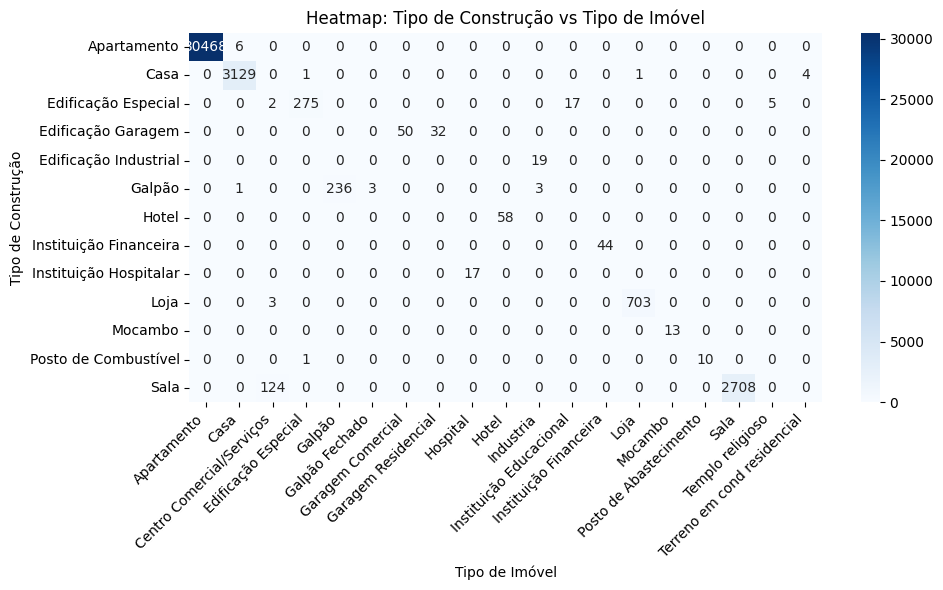

In [13]:
# Heatmap between tipo_construcao and tipo_imovel
heatmap_data = pd.crosstab(staging_dataset['tipo_construcao'], staging_dataset['tipo_imovel'])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Heatmap: Tipo de Construção vs Tipo de Imóvel")
plt.xlabel("Tipo de Imóvel")
plt.ylabel("Tipo de Construção")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

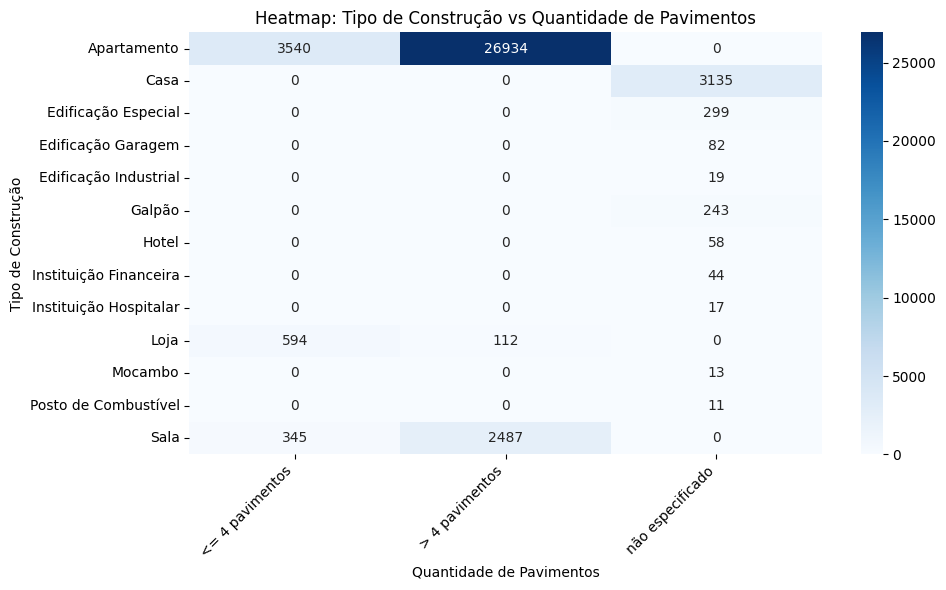

In [14]:
# Heatmap between tipo_construcao and quantidade_pavimentos
heatmap_data = pd.crosstab(staging_dataset['tipo_construcao'], staging_dataset['quantidade_pavimentos'])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Heatmap: Tipo de Construção vs Quantidade de Pavimentos")
plt.xlabel("Quantidade de Pavimentos")
plt.ylabel("Tipo de Construção")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Data normalization

**create primary key**

In [15]:
def add_row_id(df, id_column='id'):
    """
    Adds a unique sequential ID for each row in the DataFrame as the first column.

    Args:
        df (pd.DataFrame): The DataFrame to process.
        id_column (str): Name of the new ID column.

    Returns:
        pd.DataFrame: DataFrame with the ID column as the first column.
    """
    df_with_id = df.copy()
    df_with_id[id_column] = range(1, len(df_with_id) + 1)
    # Move the id column to the first position
    cols = [id_column] + [col for col in df_with_id.columns if col != id_column]
    return df_with_id[cols]

staging_dataset = add_row_id(staging_dataset)
staging_dataset.head()

,id,logradouro,numero,complemento,valor_avaliacao,bairro,ano_construcao,area_terreno,area_construida,fracao_ideal,...,estado_conservacao,tipo_imovel,valores_financiados_sfh,cod_logradouro,latitude,longitude,ano,Distrito,quantidade_pavimentos,lixo_organico
0,1,av norte miguel arraes de alencar,3071,não informado,1068562.63,Encruzilhada,1997,438.00,511.00,1.00000,...,Regular,Galpão,0.0,46540,-8.034273,-34.896337,2023,1,não especificado,sim
1,2,av norte miguel arraes de alencar,3029,não informado,1500000.00,Encruzilhada,1957,779.33,582.44,1.00000,...,Regular,Casa,0.0,46540,-8.034435,-34.896335,2023,1,não especificado,não
2,3,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,...,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1,<= 4 pavimentos,não especificado
3,4,rua belmiro correa,133,apto 1,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,...,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1,<= 4 pavimentos,não especificado
4,5,rua belmiro correa,133,apto 2,110000.00,Encruzilhada,1970,562.05,81.00,0.18202,...,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,1,<= 4 pavimentos,não especificado


In [16]:
def create_primary_key(df, key_columns, conflict_strategy='first', verbose=True, show_examples=2):
    """
    Creates a primary key by keeping only one row for each duplicate key.
    For columns with conflicting values, shows an example of the conflict for each column.
    """
    duplicates = df[df.duplicated(subset=key_columns, keep=False)]
    if verbose and not duplicates.empty:
        print(f"Found {len(duplicates)} rows with duplicate primary key ({key_columns}).")
        for col in df.columns:
            if col not in key_columns:
                nunique = duplicates.groupby(key_columns)[col].nunique()
                conflict_keys = nunique[nunique > 1].index 
                if len(conflict_keys) > 0:
                    print(f"\nColumn '{col}' has conflicting values for {len(conflict_keys)} keys. Example(s):")
                    for i, key in enumerate(conflict_keys):
                        if i >= show_examples:
                            break
                        # Handle single-column and multi-column keys
                        if isinstance(key, tuple):
                            key_dict = dict(zip(key_columns, key))
                            mask = (df[key_columns] == pd.Series(key, index=key_columns)).all(axis=1)
                        else:
                            key_dict = {key_columns[0]: key}
                            mask = df[key_columns[0]] == key
                        rows = df.loc[mask]
                        print(f"  Key: {key_dict}")
                        display(rows[[*key_columns, col]])
    if conflict_strategy == 'first':
        df_clean = df.drop_duplicates(subset=key_columns, keep='first').reset_index(drop=True)
    elif conflict_strategy == 'last':
        df_clean = df.drop_duplicates(subset=key_columns, keep='last').reset_index(drop=True)
    elif conflict_strategy == 'random':
        df_clean = df.sample(frac=1).drop_duplicates(subset=key_columns, keep='first').reset_index(drop=True)
    else:
        raise ValueError("conflict_strategy must be 'first', 'last', or 'random'")
    if verbose:
        print(f"\nResulting DataFrame has {len(df_clean)} unique rows by primary key {key_columns}.")
    return df_clean

In [17]:
def create_dim_localizacao(df):
    """
    Creates the location dimension table by extracting bairro, latitude, longitude and complemento information.

    Args:
        df (pd.DataFrame): Original DataFrame containing cod_logradouro, numero, bairro, latitude, longitude and complemento.

    Returns:
        tuple: (df_main, dim_localizacao)
            df_main: Original DataFrame without the location columns.
            dim_localizacao: Dimension table with unique (cod_logradouro, numero, complemento) as primary key and bairro, latitude, longitude.
    """
    # Create the location dimension table (unique pairs)
    dim_localizacao = (
        df[['cod_logradouro', 'numero', 'bairro', 'latitude', 'longitude', 'complemento']]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    # Normalize using create_primary_key for composite key
    dim_localizacao = create_primary_key(
        dim_localizacao,
        key_columns=['cod_logradouro', 'numero', 'complemento'],
        conflict_strategy='first',
        verbose=True,
        show_examples=5,
    )
    # Remove location columns from main table
    df_main = df.drop(columns=['bairro', 'latitude', 'longitude', 'complemento'])
    return df_main, dim_localizacao

staging_dataset, dim_localizacao_table = create_dim_localizacao(staging_dataset)
dim_localizacao_table.head()

Found 74 rows with duplicate primary key (['cod_logradouro', 'numero', 'complemento']).

Column 'latitude' has conflicting values for 26 keys. Example(s):
  Key: {'cod_logradouro': 9164, 'numero': 1295, 'complemento': 'apto 2701 edf cais da aurora'}


,cod_logradouro,numero,complemento,latitude
25077,9164,1295,apto 2701 edf cais da aurora,-8.053501
25078,9164,1295,apto 2701 edf cais da aurora,-8.053193


  Key: {'cod_logradouro': 9164, 'numero': 1295, 'complemento': 'apto 302 edf cais da aurora'}


,cod_logradouro,numero,complemento,latitude
818,9164,1295,apto 302 edf cais da aurora,-8.053501
819,9164,1295,apto 302 edf cais da aurora,-8.053193


  Key: {'cod_logradouro': 9164, 'numero': 1295, 'complemento': 'apto 601 edf cais da aurora'}


,cod_logradouro,numero,complemento,latitude
25079,9164,1295,apto 601 edf cais da aurora,-8.053501
25080,9164,1295,apto 601 edf cais da aurora,-8.053193


  Key: {'cod_logradouro': 9792, 'numero': 94, 'complemento': 'edif especial 94'}


,cod_logradouro,numero,complemento,latitude
19695,9792,94,edif especial 94,-8.081054
19696,9792,94,edif especial 94,-8.081166


  Key: {'cod_logradouro': 17710, 'numero': 204, 'complemento': 'não informado'}


,cod_logradouro,numero,complemento,latitude
19052,17710,204,não informado,-8.047248
19053,17710,204,não informado,-8.047780



Column 'longitude' has conflicting values for 26 keys. Example(s):
  Key: {'cod_logradouro': 9164, 'numero': 1295, 'complemento': 'apto 2701 edf cais da aurora'}


,cod_logradouro,numero,complemento,longitude
25077,9164,1295,apto 2701 edf cais da aurora,-34.876255
25078,9164,1295,apto 2701 edf cais da aurora,-34.876535


  Key: {'cod_logradouro': 9164, 'numero': 1295, 'complemento': 'apto 302 edf cais da aurora'}


,cod_logradouro,numero,complemento,longitude
818,9164,1295,apto 302 edf cais da aurora,-34.876255
819,9164,1295,apto 302 edf cais da aurora,-34.876535


  Key: {'cod_logradouro': 9164, 'numero': 1295, 'complemento': 'apto 601 edf cais da aurora'}


,cod_logradouro,numero,complemento,longitude
25079,9164,1295,apto 601 edf cais da aurora,-34.876255
25080,9164,1295,apto 601 edf cais da aurora,-34.876535


  Key: {'cod_logradouro': 9792, 'numero': 94, 'complemento': 'edif especial 94'}


,cod_logradouro,numero,complemento,longitude
19695,9792,94,edif especial 94,-34.911357
19696,9792,94,edif especial 94,-34.911359


  Key: {'cod_logradouro': 17710, 'numero': 204, 'complemento': 'não informado'}


,cod_logradouro,numero,complemento,longitude
19052,17710,204,não informado,-34.958227
19053,17710,204,não informado,-34.958370



Resulting DataFrame has 33078 unique rows by primary key ['cod_logradouro', 'numero', 'complemento'].


,cod_logradouro,numero,bairro,latitude,longitude,complemento
0,46540,3071,Encruzilhada,-8.034273,-34.896337,não informado
1,46540,3029,Encruzilhada,-8.034435,-34.896335,não informado
2,10715,133,Encruzilhada,-8.035013,-34.895903,apto 1
3,10715,133,Encruzilhada,-8.035013,-34.895903,apto 2
4,10715,133,Encruzilhada,-8.035013,-34.895903,apto 3


In [18]:
# Verificar colunas disponíveis no DataFrame antes de criar dimensões
print("Colunas disponíveis no staging_dataset:")
print(list(staging_dataset.columns))
print(f"\nForma do DataFrame: {staging_dataset.shape}")
print(f"\nTipos de dados:")
print(staging_dataset.dtypes)

Colunas disponíveis no staging_dataset:
['id', 'logradouro', 'numero', 'valor_avaliacao', 'ano_construcao', 'area_terreno', 'area_construida', 'fracao_ideal', 'padrao_acabamento', 'tipo_construcao', 'tipo_ocupacao', 'data_transacao', 'estado_conservacao', 'tipo_imovel', 'valores_financiados_sfh', 'cod_logradouro', 'ano', 'Distrito', 'quantidade_pavimentos', 'lixo_organico']

Forma do DataFrame: (37933, 20)

Tipos de dados:
id                                  int64
logradouro                         object
numero                              int64
valor_avaliacao                   float64
ano_construcao                      int64
area_terreno                      float64
area_construida                   float64
fracao_ideal                      float64
padrao_acabamento                category
tipo_construcao                  category
tipo_ocupacao                    category
data_transacao             datetime64[ns]
estado_conservacao               category
tipo_imovel                

In [19]:
def create_dim_tempo(df):
    """
    Creates the time dimension table by extracting temporal information from data_transacao.

    Args:
        df (pd.DataFrame): Original DataFrame containing data_transacao and ano columns.

    Returns:
        tuple: (df_main, dim_tempo)
            df_main: Original DataFrame without the temporal columns.
            dim_tempo: Dimension table with unique data_transacao as primary key and temporal attributes.
    """
    # Create the time dimension table with temporal attributes
    dim_tempo = df[['data_transacao', 'ano']].copy()
    
    # Extract additional temporal attributes
    dim_tempo['mes'] = dim_tempo['data_transacao'].dt.month
    dim_tempo['trimestre'] = dim_tempo['data_transacao'].dt.quarter
    dim_tempo['dia_semana'] = dim_tempo['data_transacao'].dt.dayofweek
    dim_tempo['dia'] = dim_tempo['data_transacao'].dt.day
    dim_tempo['nome_mes'] = dim_tempo['data_transacao'].dt.month_name()
    dim_tempo['nome_dia_semana'] = dim_tempo['data_transacao'].dt.day_name()
    
    # Remove duplicates and reset index
    dim_tempo = dim_tempo.drop_duplicates().reset_index(drop=True)
    
    # Normalize using create_primary_key for data_transacao
    dim_tempo = create_primary_key(
        dim_tempo,
        key_columns=['data_transacao'],  # ← CHAVE PRIMÁRIA: data_transacao
        conflict_strategy='first',
        verbose=True,
        show_examples=5,
    )
    
    # Remove temporal columns from main table (keeping data_transacao for joins)
    df_main = df.drop(columns=['ano'])
    
    return df_main, dim_tempo

staging_dataset, dim_tempo_table = create_dim_tempo(staging_dataset)
dim_tempo_table.head()


Resulting DataFrame has 801 unique rows by primary key ['data_transacao'].


,data_transacao,ano,mes,trimestre,dia_semana,dia,nome_mes,nome_dia_semana
0,2023-12-21,2023,12,4,3,21,December,Thursday
1,2023-11-17,2023,11,4,4,17,November,Friday
2,2023-09-22,2023,9,3,4,22,September,Friday
3,2023-09-26,2023,9,3,1,26,September,Tuesday
4,2023-11-07,2023,11,4,1,7,November,Tuesday


In [20]:
def create_dim_construcao(df):
    """
    Creates the construction dimension table by extracting construction-related information.

    Args:
        df (pd.DataFrame): Original DataFrame containing construction attributes.

    Returns:
        tuple: (df_main, dim_construcao)
            df_main: Original DataFrame without the construction columns.
            dim_construcao: Dimension table with unique id as primary key and construction attributes.
    """
    # Create the construction dimension table
    dim_construcao = (
        df[['id', 'tipo_construcao', 'padrao_acabamento', 'estado_conservacao', 'quantidade_pavimentos', 'area_terreno', 'area_construida']]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    
    # Normalize using create_primary_key for id
    dim_construcao = create_primary_key(
        dim_construcao,
        key_columns=['id'],  # ← CHAVE PRIMÁRIA: id
        conflict_strategy='first',
        verbose=True,
        show_examples=5,
    )
    
    # Remove construction columns from main table
    df_main = df.drop(columns=['tipo_construcao', 'padrao_acabamento', 'estado_conservacao', 'quantidade_pavimentos', 'area_terreno', 'area_construida'])
    
    return df_main, dim_construcao

staging_dataset, dim_construcao_table = create_dim_construcao(staging_dataset)
dim_construcao_table.head()


Resulting DataFrame has 37933 unique rows by primary key ['id'].


,id,tipo_construcao,padrao_acabamento,estado_conservacao,quantidade_pavimentos,area_terreno,area_construida
0,1,Galpão,Médio,Regular,não especificado,438.00,511.00
1,2,Casa,Médio,Regular,não especificado,779.33,582.44
2,3,Apartamento,Simples,Bom,<= 4 pavimentos,562.05,121.00
3,4,Apartamento,Simples,Bom,<= 4 pavimentos,562.05,121.00
4,5,Apartamento,Simples,Bom,<= 4 pavimentos,562.05,81.00


In [21]:
def create_dim_imovel(df):
    """
    Creates the property dimension table by extracting property-related information.

    Args:
        df (pd.DataFrame): Original DataFrame containing property attributes.

    Returns:
        tuple: (df_main, dim_imovel)
            df_main: Original DataFrame without the property columns.
            dim_imovel: Dimension table with unique id as primary key and property attributes.
    """
    # Create the property dimension table
    dim_imovel = (
        df[['id', 'tipo_imovel', 'tipo_ocupacao', 'lixo_organico']]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    
    # Normalize using create_primary_key for id
    dim_imovel = create_primary_key(
        dim_imovel,
        key_columns=['id'],  # ← CHAVE PRIMÁRIA: id
        conflict_strategy='first',
        verbose=True,
        show_examples=5,
    )
    
    # Remove property columns from main table
    df_main = df.drop(columns=['tipo_imovel', 'tipo_ocupacao', 'lixo_organico'])
    
    return df_main, dim_imovel

staging_dataset, dim_imovel_table = create_dim_imovel(staging_dataset)
dim_imovel_table.head()


Resulting DataFrame has 37933 unique rows by primary key ['id'].


,id,tipo_imovel,tipo_ocupacao,lixo_organico
0,1,Galpão,Comercial,sim
1,2,Casa,Comercial,não
2,3,Apartamento,Residencial,não especificado
3,4,Apartamento,Residencial,não especificado
4,5,Apartamento,Residencial,não especificado


In [22]:
def create_dim_comercial(df):
    """
    Creates the commercial dimension table by extracting financial transaction information.

    Args:
        df (pd.DataFrame): Original DataFrame containing commercial attributes.

    Returns:
        tuple: (df_main, dim_comercial)
            df_main: Original DataFrame without the commercial columns.
            dim_comercial: Dimension table with unique id as primary key and commercial attributes.
    """
    # Create the commercial dimension table
    dim_comercial = (
        df[['id', 'valor_avaliacao', 'fracao_ideal', 'valores_financiados_sfh']]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    
    # Calculate ITBI: Valor_Avaliacao × 0.03 (3%)
    dim_comercial['valor_itbi'] = dim_comercial['valor_avaliacao'] * 0.03
    
    # Round ITBI value to 2 decimal places for currency precision
    dim_comercial['valor_itbi'] = dim_comercial['valor_itbi'].round(2)
    
    # Normalize using create_primary_key for id
    dim_comercial = create_primary_key(
        dim_comercial,
        key_columns=['id'],  # ← CHAVE PRIMÁRIA: id
        conflict_strategy='first',
        verbose=True,
        show_examples=5,
    )
    
    # Remove commercial columns from main table
    df_main = df.drop(columns=['valor_avaliacao', 'fracao_ideal', 'valores_financiados_sfh'])
    
    return df_main, dim_comercial

staging_dataset, dim_comercial_table = create_dim_comercial(staging_dataset)
dim_comercial_table.head()


Resulting DataFrame has 37933 unique rows by primary key ['id'].


,id,valor_avaliacao,fracao_ideal,valores_financiados_sfh,valor_itbi
0,1,1068562.63,1.00000,0.0,32056.88
1,2,1500000.00,1.00000,0.0,45000.00
2,3,110000.00,0.27191,0.0,3300.00
3,4,110000.00,0.27191,0.0,3300.00
4,5,110000.00,0.18202,0.0,3300.00


In [23]:
staging_dataset.head()

,id,logradouro,numero,ano_construcao,data_transacao,cod_logradouro,Distrito
0,1,av norte miguel arraes de alencar,3071,1997,2023-12-21,46540,1
1,2,av norte miguel arraes de alencar,3029,1957,2023-11-17,46540,1
2,3,rua belmiro correa,133,1970,2023-09-22,10715,1
3,4,rua belmiro correa,133,1970,2023-09-26,10715,1
4,5,rua belmiro correa,133,1970,2023-09-22,10715,1


#  DATABASE PREPARATION - POSTGRESQL INSERTION

## Preparing Consolidated Dataset for Database Storage
Now we'll prepare our transformed and validated ITBI dataset for insertion into PostgreSQL database. This includes database connection setup and data preparation.

In [26]:
import json
import psycopg2
from sqlalchemy import create_engine

In [ ]:
# Carregar o arquivo JSON com as configurações de conexão
with open('config.json', 'r') as config_file:
    config = json.load(config_file)['postgresconnection']

# Conectar no banco PostgreSQL
connection = psycopg2.connect(
    host=config['host'],
    port=config['port'],
    database=config['database'],
    user=config['user'],
    password=config['password']
)

print("✅ Conexão PostgreSQL estabelecida com sucesso!")

❌ Erro ao conectar no PostgreSQL: 'utf-8' codec can't decode byte 0xe7 in position 78: invalid continuation byte
🔧 Verifique suas credenciais e se o PostgreSQL está rodando.


In [ ]:
# Conectar o psycopg2 com o SQLAlchemy
engine = create_engine(f'postgresql+psycopg2://{config["user"]}:{config["password"]}@{config["host"]}:{config["port"]}/{config["database"]}', creator=lambda: connection)

# Inserir os DataFrames da nova modelagem dimensional no banco de dados
cursor = connection.cursor()

target_schema = 'star_schema_itbi'

# Criar o schema para a modelagem estrela
cursor.execute(f"CREATE SCHEMA IF NOT EXISTS {target_schema};")

# Inserir as tabelas da modelagem dimensional
staging_dataset.to_sql('fact_transactions', engine, schema=target_schema, if_exists='replace', index=False)
dim_localizacao_table.to_sql('dim_localizacao', engine, schema=target_schema, if_exists='replace', index=False)
dim_tempo_table.to_sql('dim_tempo', engine, schema=target_schema, if_exists='replace', index=False)
dim_construcao_table.to_sql('dim_construcao', engine, schema=target_schema, if_exists='replace', index=False)
dim_imovel_table.to_sql('dim_imovel', engine, schema=target_schema, if_exists='replace', index=False)
dim_comercial_table.to_sql('dim_comercial', engine, schema=target_schema, if_exists='replace', index=False)

# Adicionar chaves primárias
add_primary_key_query = f"""
-- Tabela Fato
ALTER TABLE {target_schema}.fact_transactions
ADD CONSTRAINT fact_transactions_pkey PRIMARY KEY (id);

-- Dimensões
ALTER TABLE {target_schema}.dim_localizacao
ADD CONSTRAINT dim_localizacao_pkey PRIMARY KEY (cod_logradouro, numero, complemento);

ALTER TABLE {target_schema}.dim_tempo
ADD CONSTRAINT dim_tempo_pkey PRIMARY KEY (data_transacao);

ALTER TABLE {target_schema}.dim_construcao
ADD CONSTRAINT dim_construcao_pkey PRIMARY KEY (id);

ALTER TABLE {target_schema}.dim_imovel
ADD CONSTRAINT dim_imovel_pkey PRIMARY KEY (id);

ALTER TABLE {target_schema}.dim_comercial
ADD CONSTRAINT dim_comercial_pkey PRIMARY KEY (id);
"""
cursor.execute(add_primary_key_query)

# Adicionar chaves estrangeiras
add_foreign_keys_query = f"""
-- Foreign Keys da Tabela Fato para as Dimensões
ALTER TABLE {target_schema}.fact_transactions
ADD CONSTRAINT fk_fact_localizacao FOREIGN KEY (cod_logradouro, numero, complemento)
REFERENCES {target_schema}.dim_localizacao (cod_logradouro, numero, complemento);

ALTER TABLE {target_schema}.fact_transactions
ADD CONSTRAINT fk_fact_tempo FOREIGN KEY (data_transacao)
REFERENCES {target_schema}.dim_tempo (data_transacao);

ALTER TABLE {target_schema}.fact_transactions
ADD CONSTRAINT fk_fact_construcao FOREIGN KEY (id)
REFERENCES {target_schema}.dim_construcao (id);

ALTER TABLE {target_schema}.fact_transactions
ADD CONSTRAINT fk_fact_imovel FOREIGN KEY (id)
REFERENCES {target_schema}.dim_imovel (id);

ALTER TABLE {target_schema}.fact_transactions
ADD CONSTRAINT fk_fact_comercial FOREIGN KEY (id)
REFERENCES {target_schema}.dim_comercial (id);
"""
cursor.execute(add_foreign_keys_query)

# Confirmar as transações
connection.commit()

# Fechar o cursor
cursor.close()
print("✅ Modelagem Estrela criada com sucesso no PostgreSQL!")
print(f"📊 Schema: {target_schema}")
print("🌟 Tabelas criadas:")
print("   - fact_transactions (Tabela Fato)")
print("   - dim_localizacao (Dimensão Localização)")
print("   - dim_tempo (Dimensão Temporal)")
print("   - dim_construcao (Dimensão Construção)")
print("   - dim_imovel (Dimensão Imóvel)")
print("   - dim_comercial (Dimensão Comercial)")
print("🔗 Chaves primárias e estrangeiras configuradas!")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"⏱️ Tempo total de execução: {elapsed_time:.2f} segundos")

In [ ]:
cursor = connection.cursor()
# Verificar tabela fato da modelagem estrela
cursor.execute("""SELECT * FROM star_schema_itbi.fact_transactions LIMIT 5;""")
print("📊 TABELA FATO - fact_transactions:")
for table in cursor.fetchall():
    print(table)

cursor.close()

In [ ]:
cursor = connection.cursor()
# Verificar dimensão localização
cursor.execute("""SELECT * FROM star_schema_itbi.dim_localizacao LIMIT 5;""")
print("📍 DIMENSÃO LOCALIZAÇÃO - dim_localizacao:")
for table in cursor.fetchall():
    print(table)

cursor.close()

In [ ]:
cursor = connection.cursor()
# Verificar dimensão tempo
cursor.execute("""SELECT * FROM star_schema_itbi.dim_tempo LIMIT 5;""")
print("📅 DIMENSÃO TEMPO - dim_tempo:")
for table in cursor.fetchall():
    print(table)

cursor.close()

In [ ]:
cursor = connection.cursor()

# Verificar dimensão construção
cursor.execute("""SELECT * FROM star_schema_itbi.dim_construcao LIMIT 3;""")
print("🏗️ DIMENSÃO CONSTRUÇÃO - dim_construcao:")
for table in cursor.fetchall():
    print(table)

print("\n" + "="*50 + "\n")

# Verificar dimensão imóvel
cursor.execute("""SELECT * FROM star_schema_itbi.dim_imovel LIMIT 3;""")
print("🏠 DIMENSÃO IMÓVEL - dim_imovel:")
for table in cursor.fetchall():
    print(table)

print("\n" + "="*50 + "\n")

# Verificar dimensão comercial
cursor.execute("""SELECT * FROM star_schema_itbi.dim_comercial LIMIT 3;""")
print("💼 DIMENSÃO COMERCIAL - dim_comercial:")
for table in cursor.fetchall():
    print(table)

cursor.close()

In [ ]:
# Modelagem Estrela Completa - 5 Dimensões
def create_enhanced_star_schema():
    """
    Creates an enhanced star schema with 5 dimension tables for ITBI transactions data.
    
    Returns:
        tuple: (fact_table, dim_localizacao, dim_tempo, dim_construcao, dim_imovel, dim_comercial)
    """
    print("🌟 MODELAGEM ESTRELA ITBI RECIFE - 5 DIMENSÕES")
    print("="*60)
    
    # Tabela Fato (Centro da Estrela)
    fact_table = staging_dataset.copy()
    print(f"📊 Tabela Fato: {fact_table.shape[0]} transações")
    
    # Dimensões
    dimensoes = {
        "📍 Localização": dim_localizacao_table,
        "📅 Tempo": dim_tempo_table, 
        "🏗️ Construção": dim_construcao_table,
        "🏠 Imóvel": dim_imovel_table,
        "💼 Comercial": dim_comercial_table
    }
    
    for nome, dim in dimensoes.items():
        print(f"{nome}: {dim.shape[0]} registros únicos")
    
    print("="*60)
    print("✅ Schema Estrela criado com sucesso!")
    
    return (fact_table, dim_localizacao_table, dim_tempo_table, 
            dim_construcao_table, dim_imovel_table, dim_comercial_table)

# Criar e exibir o schema estrela
fact_transactions, dim_loc, dim_temp, dim_const, dim_imov, dim_com = create_enhanced_star_schema()

In [ ]:
connection.close()
print("Conexão com o banco de dados fechada.")

## 🌟 RESUMO DA MODELAGEM DIMENSIONAL

### **Estrutura da Estrela ITBI Recife**

A modelagem dimensional implementada segue o padrão **Star Schema** com 5 dimensões:

#### **📊 TABELA FATO: `fact_transactions`**
- **Chave Primária**: `id`
- **Métricas**: Não contém métricas diretas (dimensional puro)
- **Chaves Estrangeiras**: 
  - `(cod_logradouro, numero, complemento)` → dim_localizacao
  - `data_transacao` → dim_tempo
  - `id` → dim_construcao, dim_imovel, dim_comercial

#### **📍 DIMENSÃO LOCALIZAÇÃO: `dim_localizacao`**
- **Chave Primária**: `(cod_logradouro, numero, complemento)`
- **Atributos**: `bairro`, `latitude`, `longitude`

#### **📅 DIMENSÃO TEMPO: `dim_tempo`**
- **Chave Primária**: `data_transacao`
- **Atributos**: `ano`, `mes`, `trimestre`, `dia_semana`, `dia`, `nome_mes`, `nome_dia_semana`

#### **🏗️ DIMENSÃO CONSTRUÇÃO: `dim_construcao`**
- **Chave Primária**: `id`
- **Atributos**: `tipo_construcao`, `padrao_acabamento`, `estado_conservacao`, `quantidade_pavimentos`, `area_terreno`, `area_construida`

#### **🏠 DIMENSÃO IMÓVEL: `dim_imovel`**
- **Chave Primária**: `id`
- **Atributos**: `tipo_imovel`, `tipo_ocupacao`, `lixo_organico`

#### **💼 DIMENSÃO COMERCIAL: `dim_comercial`**
- **Chave Primária**: `id`
- **Atributos**: `valor_avaliacao`, `fracao_ideal`, `valores_financiados_sfh`, `valor_itbi` (calculado)

### **🔗 Relacionamentos**
- **1:1** entre fato e dimensões por `id` (construção, imóvel, comercial)
- **N:1** entre fato e localização por chave composta
- **N:1** entre fato e tempo por `data_transacao`

### **📈 Benefícios da Modelagem**
1. **Performance**: Queries otimizadas para análises multidimensionais
2. **Flexibilidade**: Análises por qualquer combinação de dimensões
3. **Escalabilidade**: Fácil adição de novas dimensões
4. **Clareza**: Separação lógica de contextos de negócio
5. **Integridade**: Chaves estrangeiras garantem consistência